In [15]:
import json

data = []
with open('../data/gpt-generated-validation.jsonl', 'r') as file:
    for line in file:
        data.append(json.loads(line))
    
# cleaned_data = [entry for entry in data if all(entry.values())]

# print(f"Original data length: {len(data)}")
# print(f"Cleaned data length: {len(cleaned_data)}")

# data = cleaned_data

# output_data = []

# for entry in data:
#     new_entry = {
#         "query": entry["passage"],
#         "pos": [entry['old_query']],
#         "neg": entry["new_queries"]  # Assuming no negative examples are provided in the current dataset
#     }
#     output_data.append(new_entry)

# with open('../data/finetuning.jsonl', 'w') as outfile:
#     for entry in output_data:
#         json.dump(entry, outfile)
#         outfile.write('\n')



# data = output_data


In [16]:
data[:10]

[{'passage': 'WHETHER YOU EAT HONEY OR NOT -- WE COULD NOT EXIST WITHOUT HONEY BEES. Till they die. Honey bees only live for about six weeks in the summer, as they literally work themselves to death. However, in the winter they can live for as long as six months as they have much less work to do. 28 to 35 days. The queens can live up to 2 years.',
  'old_query': 'What is the average lifespan of a honey bee queen?',
  'new_queries': ['How long does a honeybee live in the winter',
   'What is the lifespan of a queen bee',
   'How long do honeybees live in the summer',
   'How long do honeybees typically live',
   'What is the average lifespan of a honeybee']},
 {'passage': 'Beef heart is a rich source of all the B vitamins except folate, but it’s especially high in vitamin B-12. Three ounces provide more than 200 percent of the recommended daily intake. Vitamin B-12 must be present for several enzymes to perform their jobs.',
  'old_query': 'What are the specific health benefits of consu

In [12]:
from encoder_model import TrainedEncoder

old_model = TrainedEncoder("BAAI/bge-small-en-v1.5")


new_model = TrainedEncoder("mfine/embedding-model")




tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [7]:
new_model.push_to_hub("mfine/embedding-model")

README.md:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/mfine/embedding-model/commit/458aaa43f520e35289903924b60bb9184fbdb6b0', commit_message='Upload model', commit_description='', oid='458aaa43f520e35289903924b60bb9184fbdb6b0', pr_url=None, pr_revision=None, pr_num=None)

In [13]:
import torch
from tqdm import tqdm

# Function to evaluate embeddings
def evaluate_embeddings(data, model):
    to_delete = []
    for i in tqdm(range(len(data))):
        try:
            data[i]['passage_embedding'] = model.encode(data[i]['passage'], show_progress_bar=False)
            data[i]['old_embedding'] = model.encode(data[i]['old_query'], show_progress_bar=False)
            data[i]['new_embedding'] = model.encode(data[i]['new_queries'], show_progress_bar=False)
        except Exception as e:
            print(f"Error at index {i}: {e}")
            to_delete.append(i)
    for index in sorted(to_delete, reverse=True):
        del data[index]



    positive_similarities = []
    negative_similarities = []
    positive_similarities_rand = []
    negative_similarities_rand = []

    new_query_errors = 0
    new_query_margin_errors = 0
    new_query_margin_bad_errors = 0
    general_errors = 0
    
    for item in tqdm(data):
        passage_emb = torch.tensor(item['passage_embedding'])[0]
        import random
        sampled_data = random.sample(data, 50)
        rand_passage_emb = [torch.tensor(sampled_item['passage_embedding'])[0] for sampled_item in sampled_data]

            # Continue with the existing code to evaluate the sampled passages
        
        # Calculate cosine similarity for positive queries
        for pos_emb in item['old_embedding']:
            pos_emb = torch.tensor(pos_emb).reshape(-1)
            pos_sim = pos_emb.dot(passage_emb) / (torch.norm(pos_emb) * torch.norm(passage_emb))
            positive_similarities.append(pos_sim)

            for rand_emb in rand_passage_emb:
                positive_similarities_rand.append(pos_emb.dot(rand_emb))

        # Calculate cosine similarity for negative queries
        for neg_emb in item['new_embedding']:
            neg_emb = torch.tensor(neg_emb).reshape(-1)
            neg_sim = neg_emb.dot(passage_emb) / (torch.norm(neg_emb) * torch.norm(passage_emb))
            negative_similarities.append(neg_sim)

            rand_similarities = [neg_emb.dot(rand_emb) for rand_emb in rand_passage_emb]
               

        if pos_sim < neg_sim:
            new_query_errors += 1
        if pos_sim < neg_sim + 0.1:
            new_query_margin_errors += 1
        if neg_sim + 0.1 < pos_sim:
            new_query_margin_bad_errors += 1
        if pos_sim < max(rand_similarities):
            general_errors += 1
        

    # Calculate and print average similarities
    margin = 0.1
    avg_pos_sim = torch.mean(torch.tensor(positive_similarities))
    avg_neg_sim = torch.mean(torch.tensor(negative_similarities))
    avg_pos_sim_rand = torch.mean(torch.tensor(positive_similarities_rand))
    avg_neg_sim_rand = torch.median(torch.tensor(negative_similarities_rand))
    
    print(f"Average similarity between passages and positive queries: {avg_pos_sim:.4f}")
    print(f"Average similarity between passages and negative queries: {avg_neg_sim:.4f}")
    print(f"Average similarity between random passages and positive queries: {avg_pos_sim_rand:.4f}")

    print(f"Fraction of new queries that are closer to the passages than the old queries: {new_query_errors / len(data):.4f}")
    print(f"Fraction of passages that are closer to a random query than the true query: {general_errors / len(data):.4f}")
    print(f"Average margin loss:  {new_query_margin_errors / len(data):.4f}")

    
    # Evaluate if positive queries are more similar than negative ones
    if avg_pos_sim > avg_neg_sim:
        print("Model is correctly associating positive queries closer to the passages than negative ones.")
    else:
        print("Model needs improvement. Negative queries are closer or equal to passages than positive ones.")



In [71]:
evaluate_embeddings(data, old_model)

100%|██████████| 2671/2671 [00:04<00:00, 592.60it/s]


Average similarity between passages and positive queries: 0.8269
Average similarity between passages and negative queries: 0.7801
Average similarity between random passages and positive queries: 0.4025
Fraction of new queries that are closer to the passages than the old queries: 0.2493
Fraction of passages that are closer to a random query than the true query: 0.0086
Average margin loss:  0.7540
Model is correctly associating positive queries closer to the passages than negative ones.


In [18]:
# Call the evaluation function
evaluate_embeddings(data[:100], new_model)

100%|██████████| 100/100 [00:00<00:00, 693.40it/s]

Average similarity between passages and positive queries: 0.8878
Average similarity between passages and negative queries: 0.3803
Average similarity between random passages and positive queries: 0.4695
Fraction of new queries that are closer to the passages than the old queries: 0.0000
Fraction of passages that are closer to a random query than the true query: 0.0100
Average margin loss:  0.0100
Model is correctly associating positive queries closer to the passages than negative ones.


In [40]:
query = "youngest company based in the same region as Apple"

company_1 = "Founded in 2024 in Los Altos, Simile systems produces gpus for the blockchain"
company_2 = "In 2020, Synechdoche was founded by the youngest ex-Apple engineers, based out of the New York"
company_3 = "Analogy.ai was not founded in the same region as Apple and is not the youngest company"

q_embed = model.encode(query)

print(f"Company 1 query similarity: {q_embed @ model.encode(company_1).T}")
print(f"Company 2 query similarity: {q_embed @ model.encode(company_2).T}")
print(f"Company 3 query similarity: {q_embed @ model.encode(company_3).T}")

Company 1 query similarity: [[0.5484736]]
Company 2 query similarity: [[0.73154294]]
Company 3 query similarity: [[0.7733072]]


In [80]:
from tsne_torch import TorchTSNE as TSNE

# emb_size = model.get_embedding_size()
# embeddings_tensor = torch.zeros(len(data), emb_size)

data_old = []
data_new = []

for i in tqdm(range(100)):
    # data_old[i]['passage_embedding'] = old_model.encode(data[i]['passage'], show_progress_bar=False)
    # data_old[i]['old_embedding'] = old_model.encode(data[i]['old_query'], show_progress_bar=False)
    # data_old[i]['new_embedding'] = old_model.encode(data[i]['new_queries'], show_progress_bar=False)
    data_old.append({
        "passage_embedding": old_model.encode(data[i]['passage'], show_progress_bar=False),
        "old_embedding": old_model.encode(data[i]['old_query'], show_progress_bar=False),
        "new_embedding": old_model.encode(data[i]['new_queries'][0], show_progress_bar=False)
    })
for i in tqdm(range(100)):
    # data_new[i]['passage_embedding'] = new_model.encode(data[i]['passage'], show_progress_bar=False)
    # data_new[i]['old_embedding'] = new_model.encode(data[i]['old_query'], show_progress_bar=False)
    # data_new[i]['new_embedding'] = new_model.encode(data[i]['new_queries'][0], show_progress_bar=False)
    data_new.append({
        "passage_embedding": new_model.encode(data[i]['passage'], show_progress_bar=False),
        "old_embedding": new_model.encode(data[i]['old_query'], show_progress_bar=False),
        "new_embedding": new_model.encode(data[i]['new_queries'][0], show_progress_bar=False)
    })

100%|██████████| 100/100 [00:06<00:00, 14.46it/s]


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.000s...
[t-SNE] Computed neighbors for 300 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.407551
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.862869
[t-SNE] KL divergence after 300 iterations: 0.633543
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.000s...
[t-SNE] Computed neighbors for 300 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.161996
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.938240
[t-SNE] KL divergence after 300 iterations: 0.521494


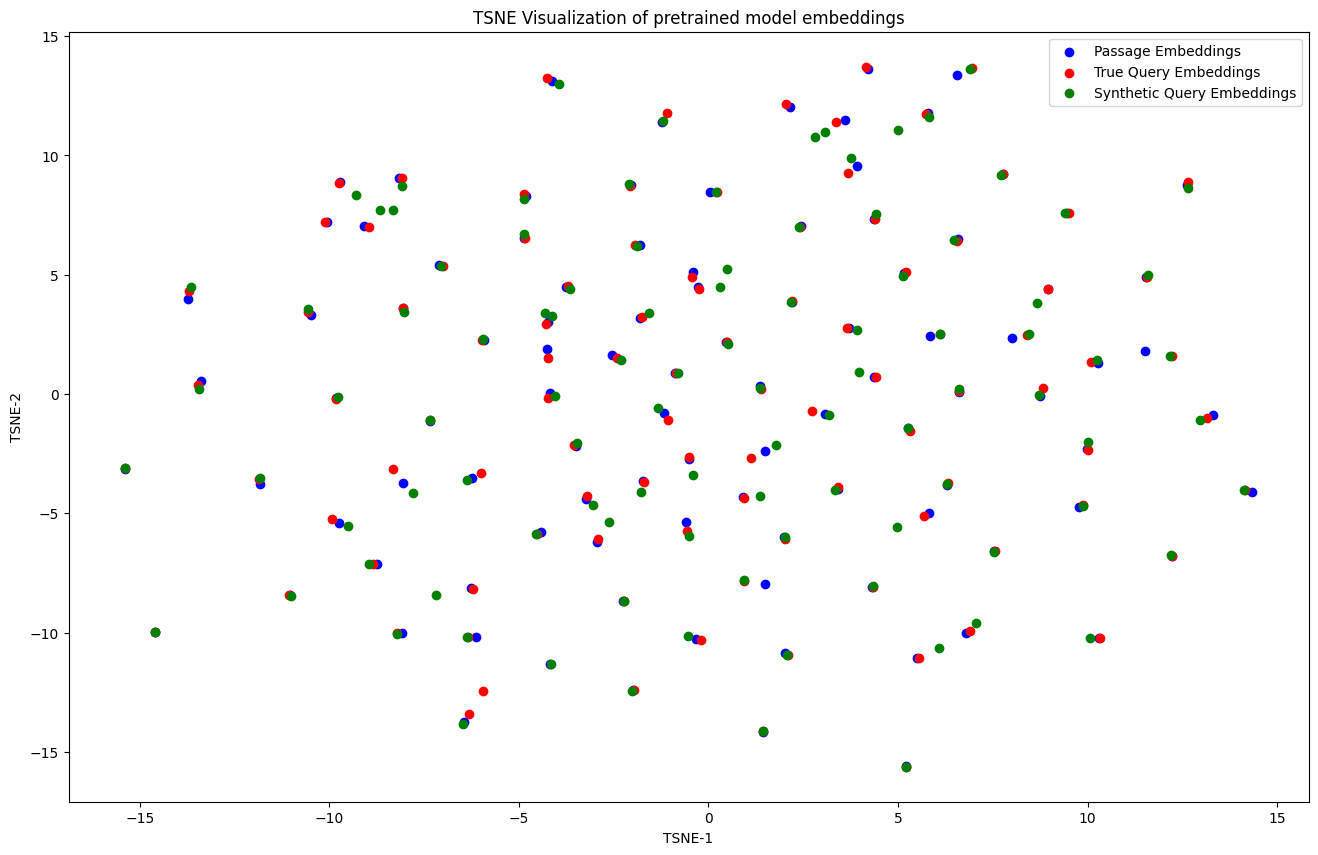

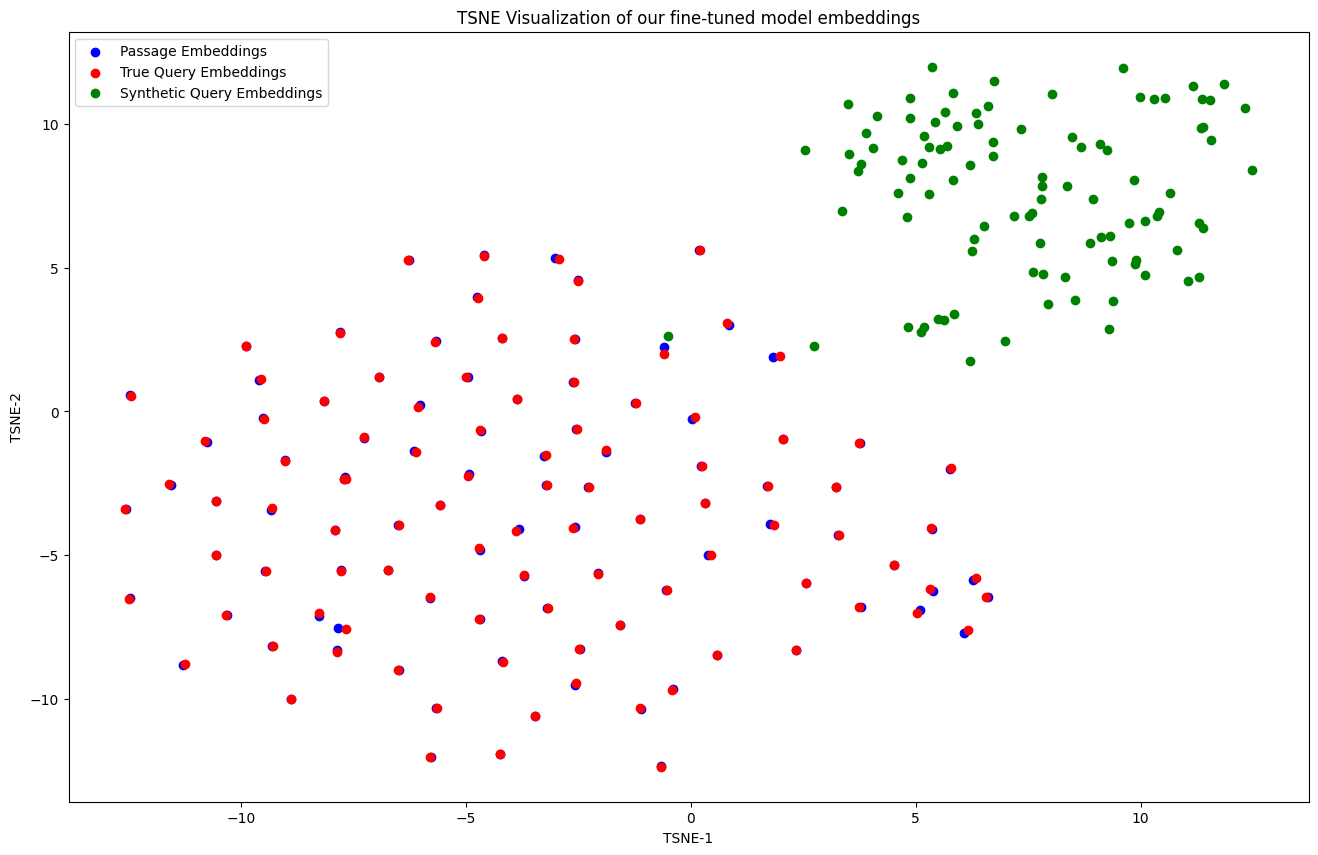

In [88]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Combine embeddings from data_old and data_new into separate arrays for TSNE
old_embeddings = np.array([d['passage_embedding'][0] for d in data_old] +
                          [d['old_embedding'][0] for d in data_old] +
                          [d['new_embedding'][0] for d in data_old])
new_embeddings = np.array([d['passage_embedding'][0] for d in data_new] +
                          [d['old_embedding'][0] for d in data_new] +
                          [d['new_embedding'][0] for d in data_new])

# Fit TSNE for old and new embeddings separately
tsne_old = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_new = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results_old = tsne_old.fit_transform(old_embeddings)
tsne_results_new = tsne_new.fit_transform(new_embeddings)

# Split the results back out
passage_embeddings_tsne_old = tsne_results_old[:len(data_old), :]
old_query_embeddings_tsne_old = tsne_results_old[len(data_old):len(data_old)*2, :]
new_query_embeddings_tsne_old = tsne_results_old[len(data_old)*2:, :]

passage_embeddings_tsne_new = tsne_results_new[:len(data_new), :]
old_query_embeddings_tsne_new = tsne_results_new[len(data_new):len(data_new)*2, :]
new_query_embeddings_tsne_new = tsne_results_new[len(data_new)*2:, :]

# Plot for old embeddings
plt.figure(figsize=(16,10))
plt.scatter(passage_embeddings_tsne_old[:,0], passage_embeddings_tsne_old[:,1], c='blue', label='Passage Embeddings')
plt.scatter(old_query_embeddings_tsne_old[:,0], old_query_embeddings_tsne_old[:,1], c='red', label='True Query Embeddings')
plt.scatter(new_query_embeddings_tsne_old[:,0], new_query_embeddings_tsne_old[:,1], c='green', label='Synthetic Query Embeddings')
plt.legend()
plt.title('TSNE Visualization of pretrained model embeddings')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.show()

# Plot for new embeddings
plt.figure(figsize=(16,10))
plt.scatter(passage_embeddings_tsne_new[:,0], passage_embeddings_tsne_new[:,1], c='blue', label='Passage Embeddings')
plt.scatter(old_query_embeddings_tsne_new[:,0], old_query_embeddings_tsne_new[:,1], c='red', label='True Query Embeddings')
plt.scatter(new_query_embeddings_tsne_new[:,0], new_query_embeddings_tsne_new[:,1], c='green', label='Synthetic Query Embeddings')
plt.legend()
plt.title('TSNE Visualization of our fine-tuned model embeddings')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.show()
